In [ ]:
# 이번 시도에선 optimizer 을 설정해주고,
# callbacks (checkpoint, earlystopping) 모두 넣어주고 돌려볼 것이며,
# optimizer 의 학습율도 조정해가며 결과를 비교할 것이다.

# 여기도 마찬가지로 A005930 데이터를 필요로 한다.

# 이후 LSTM 말고 GRU도 시도를 해보겠다.

# validation_data 에 값 넣어서 다시 하기.

In [ ]:
# LSTM 원리.
# LSTM은 입력과 가중치를 곱하고,
# 절편을 더해 활성화 함수를 통과하는 셀을 여러가지 가지고 있다.
# 그리고 이러한 계산 결과는 다음 타임스텝에서 다시 사용된다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
data_x = []
data_y = []

window_size = 50
# 순차데이터를 머신러닝에 넣기 위해서
# 전처리 해주는 과정
# window_size 타임스텝만큼의 x 데이터와,
# 그로 인한 결과값 window_size+i 를
# 각각 x,y 에 담아 리턴해준다.
def making_batch(data_x, data_y, window_size):
  new_data_x = []
  new_data_y = []
  for i in range(len(data) - window_size):
    _x = data_x[i: i+window_size]
    _y = data_y[i+window_size]
    new_data_x.append(_x)
    new_data_y.append(_y)
  new_data_x = np.array(new_data_x)
  new_data_y = np.array(new_data_y)
  return new_data_x, new_data_y
# window_size 만큼의 x 데이터의 결과값이 y[window_size+1] 이 된다.
# 즉 그 전날 60일만큼의 데이터가 그 다음의 주가를 예측한다.

# 위 함수 사용법,
# X_data, y_data = making_batch(data_x, data_y, 50) 이렇게.

In [ ]:
# 삼성 데이터를 가져온다.
samsung = pd.read_csv('/content/drive/MyDrive/A005930.csv')

In [ ]:
data = samsung[['DAY','CUR_PR','HIGH_PR','LOW_PR','CLO_PR','PR_DIFF','FOR_STOR']]
data = data.rename(columns = {'DAY':'date','CUR_PR':'open','HIGH_PR':'high','LOW_PR':'low','CLO_PR':'close','PR_DIFF':'diff','FOR_STOR':'volume'})
data

,date,open,high,low,close,diff,volume
0,20210319,82100,82500,81800,81900,-1000,3268924
1,20210318,82800,83800,82600,82900,600,3267993
2,20210317,82800,82900,82000,82300,500,3265091
3,20210316,82200,83000,82100,82800,1000,3264455
4,20210315,82800,82900,81800,81800,1000,3263213
...,...,...,...,...,...,...,...
11045,19800109,9500,9800,9250,9800,450,0
11046,19800108,9350,9350,9050,9350,500,0
11047,19800107,8700,8850,8650,8850,500,0
11048,19800105,8000,8350,8000,8350,150,0


In [ ]:
data_af_180505 =data.loc[data['date']>20180505]
data = data_af_180505[::-1]
data.reset_index(drop=True, inplace=True)
# 날짜를 순서대로 바꿔주고, 인덱스도 아예 변환해준다.

In [ ]:
data

,date,open,high,low,close,diff,volume
0,20180508,52600,53200,51900,52600,700,3389501
1,20180509,52600,52800,50900,50900,1700,3388504
2,20180510,51700,51700,50600,51600,700,3387180
3,20180511,52000,52200,51200,51300,300,3387568
4,20180514,51000,51100,49900,50100,1200,3384973
...,...,...,...,...,...,...,...
700,20210315,82800,82900,81800,81800,1000,3263213
701,20210316,82200,83000,82100,82800,1000,3264455
702,20210317,82800,82900,82000,82300,500,3265091
703,20210318,82800,83800,82600,82900,600,3267993


In [ ]:
from sklearn.preprocessing import MinMaxScaler
# 이제 메모리를 아끼기 위해 숫자를 scaling 한다.
scaler = MinMaxScaler()

In [ ]:
scaled_data = data[['open','high','low','volume','close']]
scaled_data

,open,high,low,volume,close
0,52600,53200,51900,3389501,52600
1,52600,52800,50900,3388504,50900
2,51700,51700,50600,3387180,51600
3,52000,52200,51200,3387568,51300
4,51000,51100,49900,3384973,50100
...,...,...,...,...,...
700,82800,82900,81800,3263213,81800
701,82200,83000,82100,3264455,82800
702,82800,82900,82000,3265091,82300
703,82800,83800,82600,3267993,82900


In [ ]:
scaler.fit(scaled_data)
scaled_data = scaler.transform(scaled_data)

In [ ]:
scaled_data
# 'open','high','low','volume','close' 이 순서.

array([[0.28666036, 0.26351351, 0.28584995, 0.64180268, 0.28291317],
       [0.28666036, 0.25675676, 0.2668566 , 0.63694361, 0.25116713],
       [0.26963103, 0.23817568, 0.26115859, 0.63049083, 0.26423903],
       ...,
       [0.85808893, 0.7652027 , 0.85754986, 0.0354659 , 0.83753501],
       [0.85808893, 0.78040541, 0.86894587, 0.04960937, 0.8487395 ],
       [0.8448439 , 0.75844595, 0.85375119, 0.05414679, 0.83006536]])

In [ ]:
scaled = scaled_data[:,0:4] # data
scaled_target = scaled_data[:,4] # target

In [ ]:
print(scaled.shape)
print(scaled_target.shape)
# 'open','high','low','volume'
scaled

(705, 4)
(705,)


array([[0.28666036, 0.26351351, 0.28584995, 0.64180268],
       [0.28666036, 0.25675676, 0.2668566 , 0.63694361],
       [0.26963103, 0.23817568, 0.26115859, 0.63049083],
       ...,
       [0.85808893, 0.7652027 , 0.85754986, 0.0354659 ],
       [0.85808893, 0.78040541, 0.86894587, 0.04960937],
       [0.8448439 , 0.75844595, 0.85375119, 0.05414679]])

In [ ]:
# 여기까지 scaling 하고, target 데이터와 일반 데이터 구분해줌.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# 이제 가진 데이터들을 LSTM에 사용가능한 시계열에 맞게 변환하고,
# train set 과 test set 을 나눠줄 것이다.
window_size=20

In [ ]:
X, y = making_batch(scaled, scaled_target, window_size)

In [ ]:
# 종가만으로 batch 만드는 프로그램.
def making_batch_pr(data_y, window_size):
  new_data_x = []
  new_data_y = []
  for i in range(len(data) - window_size):
    _x = data_y[i: i+window_size] # 종가 20일치
    _y = data_y[i+window_size] # 그다음 하루의 종가
    new_data_x.append(_x) # 20일치 x에 넣고
    new_data_y.append(_y) # 1일치 y에 넣는다.
  new_data_x = np.array(new_data_x) # ndarray 로 변환
  new_data_y = np.array(new_data_y) # ndarray 로 변환
  return new_data_x, new_data_y
# window_size 만큼의 x 데이터의 결과값이 y[window_size+1] 이 된다.
# 즉 그 전날 60일만큼의 데이터가 그 다음의 주가를 예측한다.

# 위 함수 사용법,
# X_data, y_data = making_batch(data_x, data_y, 50) 이렇게.

In [ ]:
X_pr, y_pr = making_batch_pr(scaled_target, window_size)

In [ ]:
print("X:", X.shape)
print("X 이전 : ", scaled.shape)
print("가격데이터 배치====")
print("X_pr : ", X_pr.shape)
print("y_pr : ",y_pr.shape)

X: (685, 20, 4)
X 이전 :  (705, 4)
가격데이터 배치====
X_pr :  (685, 20)
y_pr :  (685,)


In [ ]:
new_X_pr = X_pr.reshape(len(X_pr),window_size,1)
new_y_pr = y_pr.reshape(len(y_pr),1)


(685, 20, 1)
(685, 1)


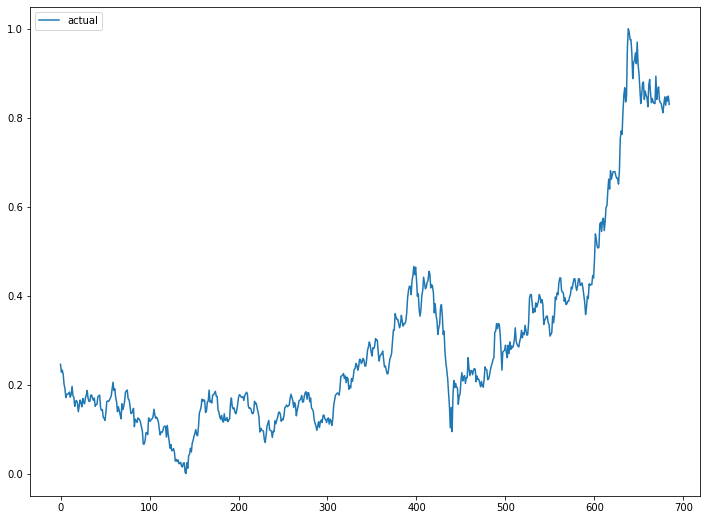

In [ ]:
X_pr = new_X_pr
y_pr = new_y_pr
print(X_pr.shape)
print(y_pr.shape)

plt.figure(figsize=(12, 9))
plt.plot(y_pr, label='actual')
plt.legend()
plt.show()

In [ ]:
# 이제 LSTM 에 훈련을 돌릴 수 있는 배치를 만듬.
# LSTM 모델을 만들고, Optimizer 을 만들고, compile 을 돌리자.
# https://teddylee777.github.io/tensorflow/lstm-stock-forecast 여기 참조
# 위 링크에서는 왜 y값, 즉 가격만 넣어주지?

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [ ]:

# 가격데이터 쓸 것,
# X_pr, y_pr,
# size는 (685, 20, 1)
# (685, 1)
model = Sequential()
model.add(LSTM(units = 16, activation='relu', return_sequences = True, input_shape=(window_size,1)))
model.add(Dropout(0.1))
model.add(LSTM(units = 10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 16)            1152      
_________________________________________________________________
dropout (Dropout)            (None, 20, 16)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                1080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 2,243
Trainable params: 2,243
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = Huber() 
adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)
# learning_rate 는 필요에 따라 조정할 예정.
earlystopping = EarlyStopping(monitor = 'val_loss', patience=10)
checkpoint=ModelCheckpoint('best_stock_model.h5',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)

In [ ]:
model.compile(loss=loss, optimizer = adam)

In [ ]:
X_pr.shape

(685, 20, 1)

In [ ]:
X_pr_train  = X_pr[:585]
X_pr_test = X_pr[585:]
y_pr_train = y_pr[:585]
y_pr_test = y_pr[585:]

In [ ]:
X_pr_train.shape

(585, 20, 1)

In [ ]:
y_pr_test.shape

(100, 1)

In [ ]:
history = model.fit(X_pr_train, y_pr_train, 
                    # validation_data = 
                    epochs = 1000,
                    callbacks = [checkpoint, earlystopping])

Epoch 1/1000
19/19 [==============================] - 0s 15ms/step - loss: 2.6737e-04
Epoch 2/1000
19/19 [==============================] - 0s 15ms/step - loss: 3.0504e-04
Epoch 3/1000
19/19 [==============================] - 0s 15ms/step - loss: 3.0514e-04
Epoch 4/1000
19/19 [==============================] - 0s 14ms/step - loss: 2.9573e-04
Epoch 5/1000
19/19 [==============================] - 0s 16ms/step - loss: 2.5684e-04
Epoch 6/1000
19/19 [==============================] - 0s 17ms/step - loss: 3.3490e-04
Epoch 7/1000
19/19 [==============================] - 0s 15ms/step - loss: 2.7619e-04
Epoch 8/1000
19/19 [==============================] - 0s 15ms/step - loss: 2.9518e-04
Epoch 9/1000
19/19 [==============================] - 0s 16ms/step - loss: 2.7460e-04
Epoch 10/1000
19/19 [==============================] - 0s 15ms/step - loss: 2.8424e-04
Epoch 11/1000
19/19 [==============================] - 0s 15ms/step - loss: 2.7784e-04
Epoch 12/1000
19/19 [==============================]

In [ ]:
pred = model.predict(X_pr_test)
pred_tr = model.predict(X_pr_train)

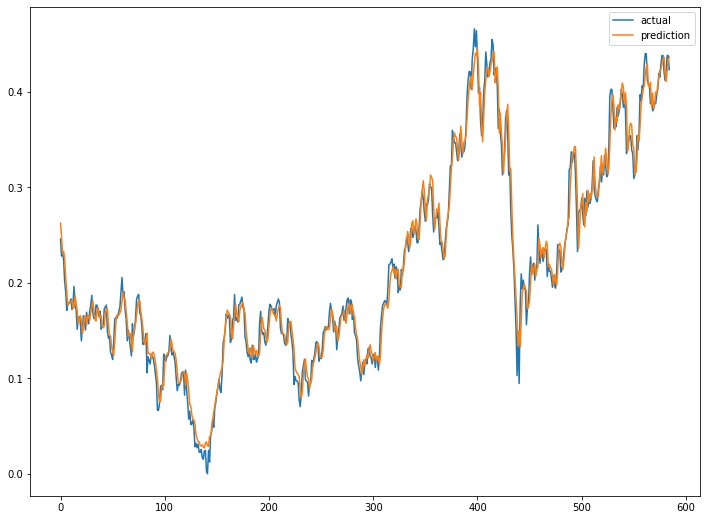

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(y_pr_train, label='actual')
plt.plot(pred_tr, label='prediction')
plt.legend()
plt.show()

# train 데이터로 예측값 찍은 것.

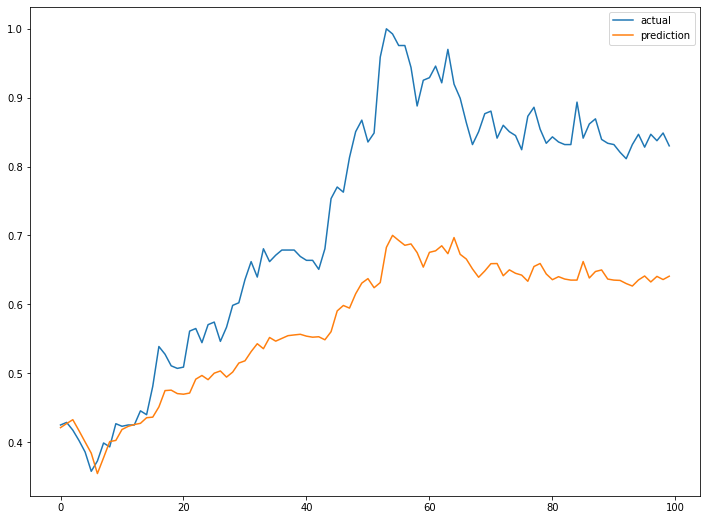

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(y_pr_test, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

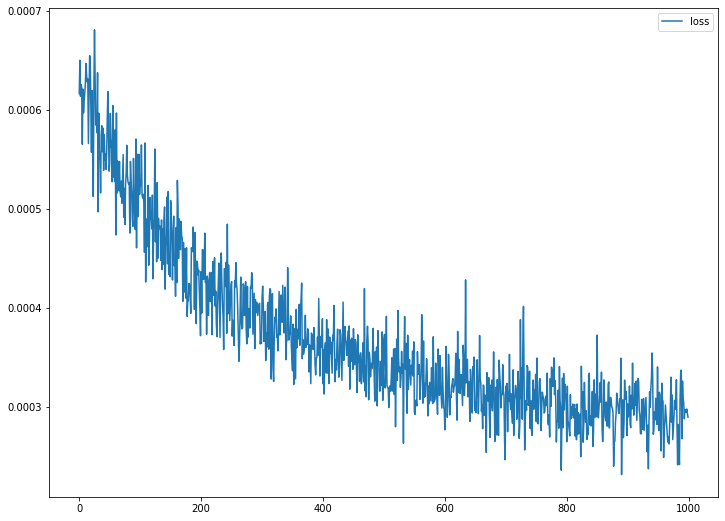

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
# 가격데이터 쓸 것,
# X_pr, y_pr,
# size는 (685, 20, 1)
# (685, 1)
loss = Huber() 
adam = tf.keras.optimizers.Adam(learning_rate = 0.0005)
# learning_rate 는 필요에 따라 조정할 예정.
earlystopping = EarlyStopping(monitor = 'val_loss', patience=10)
checkpoint=ModelCheckpoint('best_stock_model2.h5',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)
# 여긴 새로운 모델 적용해볼 것.
model2 = Sequential()
model2.add(LSTM(units = 16, activation='relu', return_sequences = True, input_shape=(window_size,1)))
model2.add(Dropout(0.1))
model2.add(LSTM(units = 10, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(units=1))

# 에포크수도 달리 해보기.
history = model2.fit(X_pr_train, y_pr_train, 
                    # validation_data = 
                    epochs = 1000,
                    callbacks = [checkpoint, earlystopping])

model2.compile(loss=loss, optimizer = adam)

In [ ]:

pred2 = model2.predict(X_pr_test)
pred_tr2 = model2.predict(X_pr_train)

plt.figure(figsize=(12, 9))
plt.plot(y_pr_train, label='actual')
plt.plot(pred_tr2, label='prediction')
plt.title('training data 의 실제값과 예측값 비교')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(y_pr_test, label='actual')
plt.plot(pred2, label='prediction')
plt.title('test data 의 실제값과 예측값 비교')
plt.legend()
plt.show()